# Energy consumption prediction and forecasting

---

My project aims to evaluate the performance of different forecasting models using data from the GREEND dataset (available at https://sourceforge.net/projects/greend/) after appropriate preprocessing.

The baseline model for comparison is ARIMA, a statistical method suited for univariate time series. I apply ARIMA to data from a specific sensor within a building. For simplicity, I focus on data from `building_1`, though this can be adjusted based on specific interests.

In addition to ARIMA, I am using LSTM and CNN models for forecasting. Initially, these models are applied to individual time series (one sensor at a time). Subsequently, I extend the analysis to treat the data from an entire building as a multivariate time series.

Given the large volume of data, I select specific date ranges for training and testing. The training data comes from a range of dates, while the test data comes from a subsequent, smaller date range. If the dataset (which is sampled every second) becomes too large, I may also perform downsampling to manage the size.

For evaluation, I use MSE as metrics for comparing the performance of each model. The predictions are made on the test set and MSE is computed comparing them with the actual values. I also plot the results for better visualization and interpretation

A further analysis was conducted using an additional set, referred to as the validation set (val), which represents data from a different sensor of a different building, in this case `building_0`. While the ARIMA model can only predict future steps for the specific time series it was trained on, using a validation set allows for a broader evaluation of overall performance and generalization of other models. This approach helps assess how well the trained model adapts to unseen data.

---

## Imports

In [1]:
import requests
import zipfile
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from numpy import log, hstack
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from tqdm import tqdm #for progress bar
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.models import Model
from keras.optimizers import Adam


## Fetching the data

I have the dataset downloaded in my drive and since it takes long to download I only have to unzip it (too big to leave it unzipped)

In [4]:
import requests
import zipfile
import os

# Download the zip file
url = "https://sourceforge.net/projects/greend/files/latest/download"
filename = "greend.zip"

# Define the directory to extract the files
extract_dir = '/content/unzipped_greend'

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes

with open(filename, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Extract the zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file
os.remove(filename)


## Preprocessing


The preprocessing steps transform a DataFrame by converting the 'timestamp' column to datetime format and setting it as the index. It also ensures all other data is numeric and handles missing values by replacing them with zeros.

In [5]:
#PREPROCESSING STEPS

def preprocess_data(df):
    """

    Parameters:
    df (pd.DataFrame): Input DataFrame with a 'timestamp' column and other numerical data.

    Returns:
    pd.DataFrame: Processed DataFrame with 'timestamp' as the index and all values converted
                  to numeric types, with missing values filled as zeros.
    """

    # Step 1: Drop rows where the 'timestamp' column contains the string 'timestamp'
    # (e.g., header rows accidentally included in the data).
    df = df[df['timestamp'] != 'timestamp'].copy()

    # Step 2: Convert the 'timestamp' column from a string to a numeric type (interpreted as seconds),
    # and then to datetime objects. Invalid values are coerced to NaN.
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

    # Step 3: Set the 'timestamp' column as the DataFrame index.
    df.set_index('timestamp', inplace=True)

    # Step 4: Convert all other columns in the DataFrame to numeric data types.
    df = df.apply(pd.to_numeric, errors='coerce')

    # Step 5: Handle missing values by replacing NaNs with zeros.
    df = df.fillna(0)

    # Return the preprocessed DataFrame.
    return df

Loads and processes CSV files from the correct directory, filtering files based on a date range and preprocessing their content. This way, we can select which data compose our train and test set.

In [6]:
def load_and_process_days(data_dir, date_range):
    """

    Parameters:
    data_dir (str): The directory path containing the CSV files.
    date_range (tuple): A tuple containing two date strings (start_date, end_date) that define the range
                        of dates to process. The format should be 'YYYY-MM-DD'.

    Returns:
    pd.DataFrame: A combined DataFrame containing the processed data from all files within the date range,
                  concatenated and sorted by timestamp.
    """

    dfs = []  # Initialize an empty list to store processed DataFrames.
    start_date, end_date = date_range  # Unpack the date range tuple into start and end dates.

    # Convert start_date and end_date from string format to pd.Timestamp for comparison purposes.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Iterate through all files in the specified directory.
    for filename in os.listdir(data_dir):
        # Process only CSV files.
        if filename.endswith('.csv'):
            # Extract the date part from the filename and convert it to a datetime object.
            date_str = filename.split('_')[1].split('.')[0]
            file_date = pd.to_datetime(date_str)

            # Check if the file's date is within the specified date range.
            if start_date <= file_date <= end_date:
                # Construct the full file path.
                filepath = os.path.join(data_dir, filename)

                # Read the CSV file, skipping any bad lines.
                df = pd.read_csv(filepath, on_bad_lines='skip')

                # Preprocess the data using the preprocess_data function.
                processed_df = preprocess_data(df)

                # Append the processed DataFrame to the list.
                dfs.append(processed_df)

    # Concatenate all the DataFrames in the list into a single DataFrame.
    combined_df = pd.concat(dfs)

    # Sort the combined DataFrame by the index (which is the timestamp).
    combined_df = combined_df.sort_index()

    # Return the final combined and sorted DataFrame.
    return combined_df


# Define the directory containing the CSV files for the building
building_number = 1
data_dir = f'/content/unzipped_greend/GREEND_0-2_300615/building{building_number}'

# Define date ranges for training and testing
train_date_range = ('2014-03-12', '2014-06-12')
test_date_range = ('2014-06-13', '2014-06-30')

# Load training and testing datasets
train_df = load_and_process_days(data_dir, train_date_range)
test_df = load_and_process_days(data_dir, test_date_range)
# Sensor data we're taking into account
sensor_name_final = '000D6F00036BB04C'

In [7]:
# Create validation set
building_number = 0
val_date_range = ('2014-06-13', '2014-07-13')
val_df = load_and_process_days(data_dir, val_date_range)
sensor_name_validation = '000D6F000353AC8C'

In [8]:
# The data is sampled every second, I just explicitly set it for the arima model
train_df.asfreq('s', method='ffill')
test_df.asfreq('s', method='ffill')
val_df.asfreq('s', method='ffill')

,000D6F00036BB04C,000D6F00029C2BD7,000D6F000353AC8C,000D6F0003562E10,000D6F0003562C48,000D6F00029C2984,000D6F000353AE51,000D6F0003562C0F,000D6F0003562BF6
timestamp,,,,,,,,,
2014-06-12 21:57:46.058346033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,44.462815
2014-06-12 21:57:47.058346033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,44.462815
2014-06-12 21:57:48.058346033,2.274737,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,44.462815
2014-06-12 21:57:49.058346033,0.000000,0.0,2.171969,0.0,2.232141,0.0,0.0,0.0,67.699200
2014-06-12 21:57:50.058346033,2.274737,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,95.159742
...,...,...,...,...,...,...,...,...,...
2014-07-13 21:57:31.058346033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2014-07-13 21:57:32.058346033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2014-07-13 21:57:33.058346033,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000


In [9]:
### IF THE DATA IS TOO LARGE

# Set the resampling interval to X minutes
n_min = 10

# Resample the training data at a X-minute frequency, take the mean for each interval, and drop any rows with NaN values.
train_df.resample(f'{n_min}min').mean().dropna()

# Adjust the frequency of the training data to X-minute intervals using padding for any missing values.
train_df = train_df.asfreq(f'{n_min}min', method='pad')

# Print the number of rows in the training dataset after resampling.
print('Train length', len(train_df))

#Do the same for the test data
test_df.resample(f'{n_min}min').mean().dropna()

test_df = test_df.asfreq(f'{n_min}min', method='pad')

print("Test length: ", len(test_df))

#Do the same for the validation data
val_df.resample(f'{n_min}min').mean().dropna()

val_df = val_df.asfreq(f'{n_min}min', method='pad')

print("Validation length: ", len(val_df))



Train length 13333
Test length:  2591
Validation length:  4464


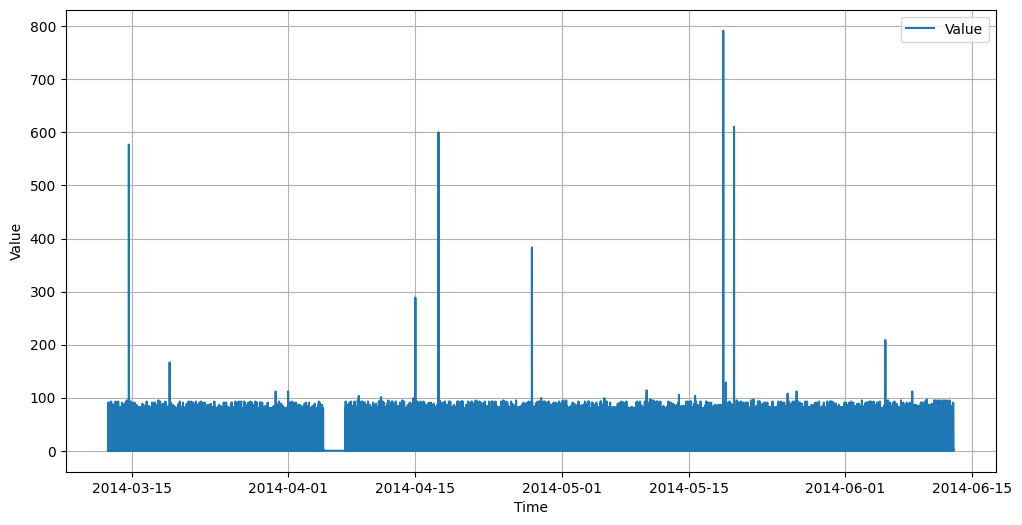

In [10]:
# Plotting train data

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(train_df.index, train_df[sensor_name_final].values, label='Value')  # Plot the time series

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## ARIMA

I use auto arima for automatically detecting best parameters for my case

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.5 MB/s eta 0:00:00


Perform the Augmented Dickey-Fuller (ADF) test on the data for the specified sensor.
It helps determine if the time series is stationary or not.

In [ ]:
# ADF test
result = adfuller(train_df[sensor_name_final])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Check if the p-value is less than 0.05, indicating the series is stationary.
# If so, print that the series is stationary; otherwise, suggest differentiation.
if result[1] < 0.05:
    print("The time series is stationary.")
    d=0
else:
    print("The time series is non-stationary, performing differentiation.")
    # Perform differentiation to make the time series stationary.
    train_df[sensor_name_final] = train_df[sensor_name_final].diff().dropna()
    d=1


ADF Statistic: -10.214803
p-value: 0.000000
The time series is stationary.


In [ ]:
from pmdarima import auto_arima

# Fit the auto_arima model
model = auto_arima(train_df[sensor_name_final],
                    start_p=0, start_q=0,
                    max_p=5, max_q=5,
                    seasonal=False,
                    d=0, trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

# Fit the model on the training data
model_fit = model.fit(train_df[sensor_name_final])

# Forecast on the test data
predictions_arima = model_fit.predict(n_periods=len(test_df[sensor_name_final]))

# Calculate Mean Squared Error
mse_arima = mean_squared_error(test_df[sensor_name_final], predictions_arima)
print(f'Mean Squared Error: {mse_arima}')



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=137181.647, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=137154.890, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=137156.216, Time=1.40 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=137148.275, Time=0.81 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=137061.700, Time=1.84 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=128093.527, Time=2.48 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=126517.120, Time=3.74 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=124848.095, Time=42.97 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=125878.919, Time=14.70 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=124695.079, Time=19.83 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=125310.483, Time=16.61 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=125021.427, Time=21.52 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=124841.908, Time=18.05 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=124802.813, Time=63.70 se

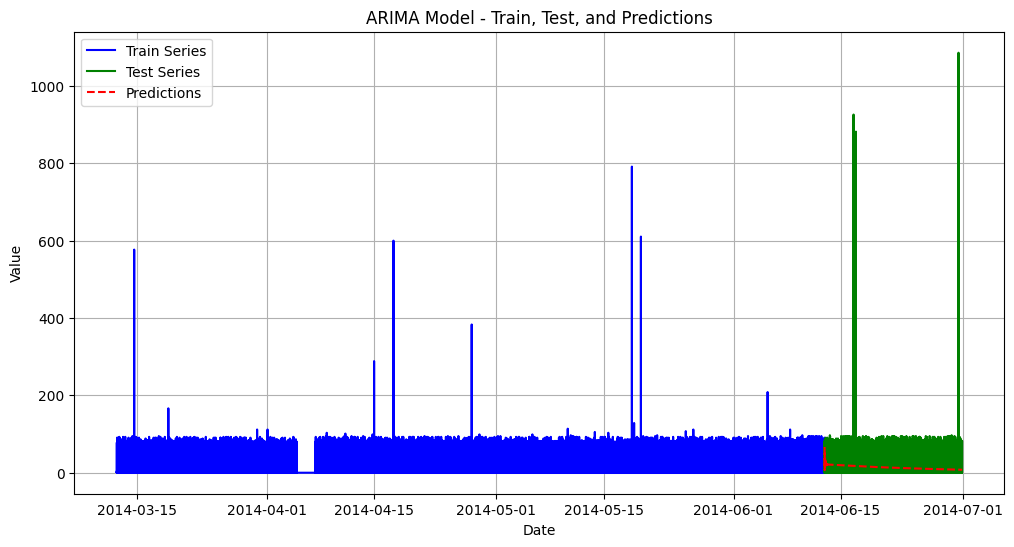

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(train_df.index, train_df[sensor_name_final], label='Train Series', color='blue')

# Plot the test data
plt.plot(test_df.index, test_df[sensor_name_final], label='Test Series', color='green')

# Plot the predictions
plt.plot(test_df.index, predictions_arima, label='Predictions', color='red', linestyle='--')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model - Train, Test, and Predictions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## UNIVARIATE

I decided to try and evaluate the performance of different neural network models using MSE as metrics and compare them with the baseline, which is the ARIMA model. The models I built take as input sequential data and are based on LSTM, CNN and GRU and variations of them: from a simple one to "more complex" and hybrid ones. First, I make an analysis considering a specific sensor data as univariate time series, then I consider all the sensor data of a building as multivariate time series

In [ ]:
#training process tracking
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.tqdm_bar = tqdm(total=self.epochs, desc="Training Progress", unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.tqdm_bar.update(1)

    def on_train_end(self, logs=None):
        self.tqdm_bar.close()

This function creates sequences of data. The function prepares input sequences (X) and their corresponding target values (Y), using a sliding window approach.

In [ ]:
import numpy as np
#This function is used both for univariate and multivariate analysis
def create_sequences(data, seq_length):
    """

    Parameters:
    data (np.ndarray or pd.Series): The input time-series data. It could be a NumPy array or a Pandas Series.
    seq_length (int): The length of each sequence (window size) used to predict the next value.

    Returns:
    tuple: A tuple containing two NumPy arrays:
           - X (np.ndarray): Array of input sequences with shape (num_samples, seq_length).
           - Y (np.ndarray): Array of target values corresponding to each input sequence,
                             with shape (num_samples,).
    """

    x, y = [], []  # Initialize empty lists to hold sequences (X) and target values (Y).

    # Iterate over the data to create sequences of length 'seq_length'.
    for i in range(len(data) - seq_length):
        # Extract a sequence of length 'seq_length' from data as input (X).
        x.append(data[i:i + seq_length])

        # The next value after the sequence is the target (Y).
        y.append(data[i + seq_length])

    # Convert the lists of sequences and targets to NumPy arrays for model input.
    return np.array(x), np.array(y)

In [ ]:
# Normalize the univariate data for train and test
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df[[sensor_name_final]].values)  # Only one sensor for univariate
scaled_test_data = scaler.transform(test_df[[sensor_name_final]].values)
scaled_val_data = scaler.transform(val_df[[sensor_name_validation]].values)

#Create sequences for univariate time
# Length of the sliding window used to create input sequences
sequence_length = 100
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)
X_val, y_val = create_sequences(scaled_val_data, sequence_length)

n_steps = sequence_length

# Reshape X for univariate LSTM input (samples, timesteps, features)
# LSTM expects input data in the form of (samples, timesteps, features), where:
# - samples: number of sequences
# - timesteps: length of each sequence (sequence_length)
# - features: number of features per timestep (1 for univariate time series)
n_features = 1  # Univariate time series has only one feature per timestep.

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))


tqdm_callback = TQDMProgressBar()

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)

### Models


#### Simple LSTM


Simple model consisting of a single lstm layer

In [ ]:
def simple_lstm_model(X_train_shape, print_summary=False):
    # Input layer
    input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="sensor_input")

    # LSTM Layer
    lstm_layer = LSTM(128, activation='relu', name="lstm_layer")(input_layer)

    # Dropout Layer
    dropout_layer = Dropout(0.5, name="dropout_layer")(lstm_layer)

    # Output Layer
    output_layer = Dense(1, name="output_layer")(dropout_layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer, name="simple_lstm_sensor_model")

    # Compile the model with a custom learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse')

    # Print model summary if required
    if print_summary:
        print(model.summary())

    return model

# Usage
model = simple_lstm_model(X_train_shape=X_train.shape, print_summary=True)

# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0,
                    callbacks=[early_stopping, lr_scheduler, tqdm_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Model: "simple_lstm_sensor_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sensor_input (InputLayer)            │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress: 100%|██████████| 10/10 [08:08<00:00, 48.84s/epoch]


78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0025
Test Loss: 0.0025921068154275417


In [ ]:
### Performance on test
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_simple = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on test: {mse_simple}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Mean Squared Error after on test: 1624.5947750923951


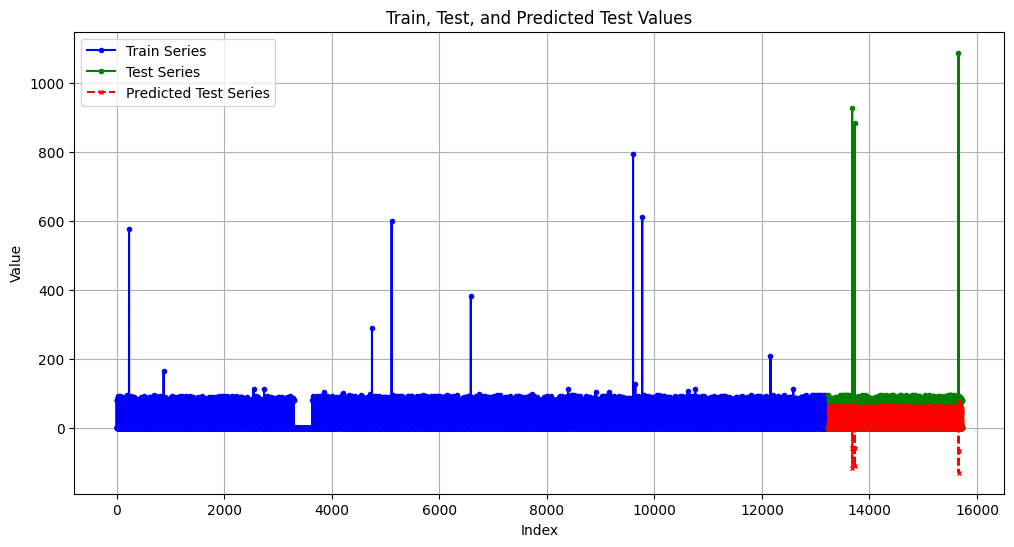

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_simple_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_simple_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step
Mean Squared Error after on validation: 439.0103578067156


#### Multi-layered LSTM

Model that uses three lstm modules interlayered by dropout layers

In [ ]:
def multilayered_lstm_model(X_train_shape, print_summary=False):
    # Input layer
    input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="input")

    # First LSTM layer with return_sequences=True
    lstm_1 = LSTM(64, activation='relu', return_sequences=True, name="lstm_1")(input_layer)
    # First Dropout layer
    dropout_1 = Dropout(0.5, name="dropout_layer_1")(lstm_1)

    # Second LSTM layer
    lstm_2 = LSTM(128, activation='relu', return_sequences=True, name="lstm_2")(dropout_1)
    # Second Dropout layer
    dropout_2 = Dropout(0.5, name="dropout_layer_2")(lstm_2)

    # Third LSTM layer
    lstm_3 = LSTM(128, activation='relu', return_sequences=False, name="lstm_3")(dropout_2)
    # Third Dropout layer
    dropout_3 = Dropout(0.5, name="dropout_layer_3")(lstm_3)

    # Dense output layer
    output_layer = Dense(1, name="output")(dropout_3)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer, name="multilayered_lstm_model")

    # Compile the model with Adam optimizer and MSE loss
    model.compile(optimizer=Adam(), loss='mse')

    # Print model summary if requested
    if print_summary:
        print(model.summary())

    return model

# Usage
model = multilayered_lstm_model(X_train_shape=X_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0,
                    callbacks=[early_stopping, lr_scheduler, tqdm_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Model: "multilayered_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_1 (Dropout)            │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_2 (Dropout)            │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_3 (Dropout)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247,425 (966.50 KB)

 Trainable params: 247,425 (966.50 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress:  30%|███       | 3/10 [06:01<14:02, 120.40s/epoch]


78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - loss: 0.0037
Test Loss: 0.0037758818361908197


In [ ]:
### Performance
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_multilayered = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after inverse scaling: {mse_multilayered}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step
Mean Squared Error after inverse scaling: 2366.520973528991


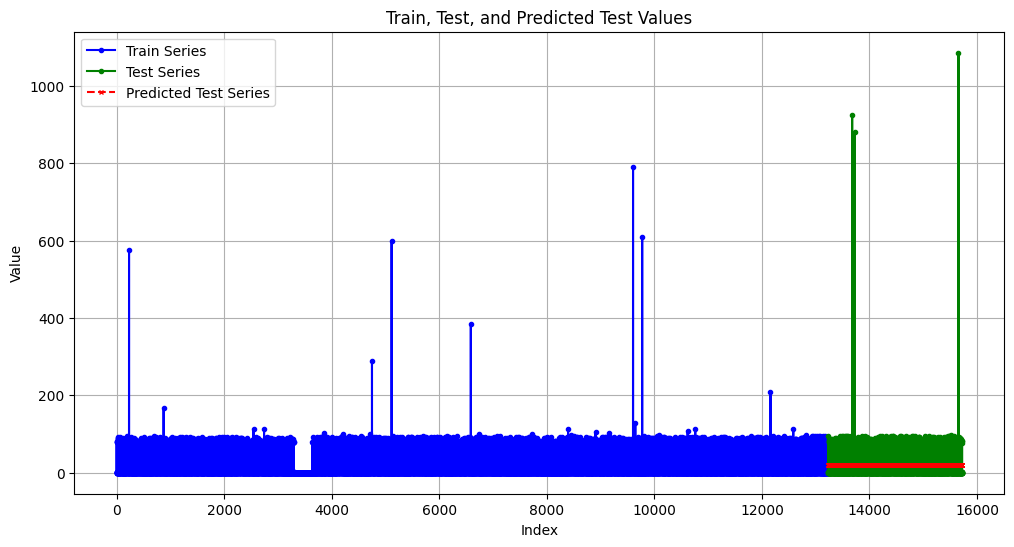

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_multilayered_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_multilayered_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step
Mean Squared Error after on validation: 824.0871523252603


#### Bidirectional LSTM

Model that uses bidirectional lstm layers

In [ ]:
def bidirectional_lstm_model(X_train_shape, print_summary=False):
    # Input layer
    input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Bidirectional LSTM layer with return_sequences=True
    bi_lstm_1 = Bidirectional(LSTM(128, activation='relu', return_sequences=True), name="bi_lstm_layer")(input_layer)
    # First Dropout layer
    dropout_1 = Dropout(0.5, name="dropout_layer")(bi_lstm_1)

    # Second Bidirectional LSTM layer
    bi_lstm_2 = Bidirectional(LSTM(50, activation='relu', return_sequences=False), name="bi_lstm_layer2")(dropout_1)
    # Second Dropout layer
    dropout_2 = Dropout(0.5, name="dropout_layer_2")(bi_lstm_2)

    # Dense output layer
    output_layer = Dense(1, name="output_layer")(dropout_2)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer, name="bidirectional_lstm_model")

    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')

    # Print model summary if requested
    if print_summary:
        print(model.summary())

    return model

# Usage
model = bidirectional_lstm_model(X_train_shape=X_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0,
                    callbacks=[early_stopping, lr_scheduler, tqdm_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Model: "bidirectional_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bi_lstm_layer (Bidirectional)        │ (None, 100, 256)            │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bi_lstm_layer2 (Bidirectional)       │ (None, 100)                 │         122,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_2 (Dropout)            │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,021 (1000.08 KB)

 Trainable params: 256,021 (1000.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress:  70%|███████   | 7/10 [16:26<07:02, 140.97s/epoch]


78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 0.0022
Test Loss: 0.0022712370846420527


In [ ]:
### Performance
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_bidirectional = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after inverse scaling: {mse_bidirectional}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step
Mean Squared Error after inverse scaling: 1423.4899947647896


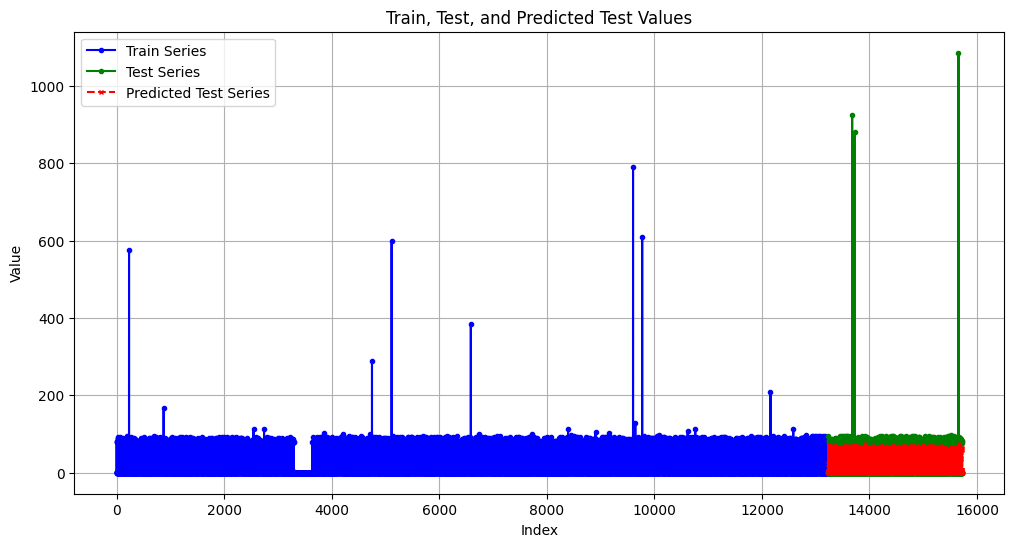

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_bidirectional_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_bidirectional_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step
Mean Squared Error after on validation: 479.1496786982042


#### CNN

1D CNN model with two convolutional layers, dropout and a final flattening layer

In [ ]:
def cnn_1d_model(X_train_shape, print_summary=False):
    # Input layer
    input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Conv1D layer
    conv1 = Conv1D(filters=64, kernel_size=32, strides=1, activation='relu', name="conv1")(input_layer)
    # First Dropout layer
    dropout_1 = Dropout(0.5, name="dropout_layer")(conv1)

    # MaxPooling layer
    max_pool1 = MaxPooling1D(pool_size=2, name="max_pool1")(dropout_1)

    # Second Conv1D layer
    conv2 = Conv1D(filters=128, kernel_size=16, strides=1, activation='relu', name="conv2")(max_pool1)
    # Second Dropout layer
    dropout_2 = Dropout(0.5, name="dropout_layer_2")(conv2)

    # MaxPooling layer
    max_pool2 = MaxPooling1D(pool_size=2, name="max_pool2")(dropout_2)

    # Flatten the output
    flatten_layer = Flatten(name="flatten_layer")(max_pool2)

    # Output layer
    output_layer = Dense(1, name="output_layer")(flatten_layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer, name="1d_cnn_model")

    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')

    # Print model summary if requested
    if print_summary:
        print(model.summary())

    return model

# Usage
model = cnn_1d_model(X_train_shape=X_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0,
                    callbacks=[early_stopping, lr_scheduler, tqdm_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Model: "1d_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 69, 64)              │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 69, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling1D)             │ (None, 34, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 19, 128)             │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_2 (Dropout)            │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool2 (MaxPooling1D)             │ (None, 9, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,465 (525.25 KB)

 Trainable params: 134,465 (525.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress:  30%|███       | 3/10 [00:45<01:45, 15.14s/epoch]


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038
Test Loss: 0.0038146371953189373


In [ ]:
### Performance
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_cnn_1 = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after inverse scaling: {mse_cnn_1}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error after inverse scaling: 2390.810783829863


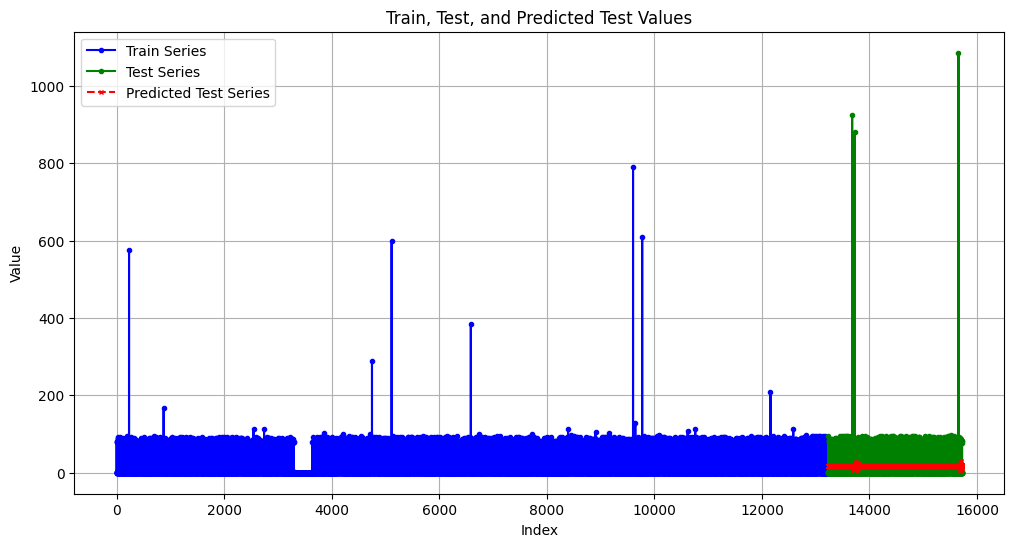

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_cnn_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_cnn_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Mean Squared Error after on validation: 566.2787572997208


#### ConvLSTM

Model that adds a LSTM layer after two convolutional layers

In [ ]:
def cnn_lstm_model(X_train_shape, print_summary=False):
    # Input layer
    input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Conv1D layer
    conv1d_layer_1 = Conv1D(filters=32, kernel_size=32, strides=1, activation='relu', name="conv1d_layer_1")(input_layer)

    # First MaxPooling1D layer
    max_pool_layer_1 = MaxPooling1D(pool_size=2, name="max_pool_layer_1")(conv1d_layer_1)

    # Second Conv1D layer
    conv1d_layer_2 = Conv1D(filters=64, kernel_size=16, strides=1, activation='relu', name="conv1d_layer_2")(max_pool_layer_1)

    # Second MaxPooling1D layer
    max_pool_layer_2 = MaxPooling1D(pool_size=2, name="max_pool_layer_2")(conv1d_layer_2)

    # LSTM layer
    lstm_layer = LSTM(64, activation='relu', name="lstm_layer")(max_pool_layer_2)

    # Dense output layer
    output_layer = Dense(1, name="output_layer")(lstm_layer)

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer, name="cnn_lstm_model")

    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')

    # Print model summary if requested
    if print_summary:
        print(model.summary())

    return model

# Usage
model = cnn_lstm_model(X_train_shape=X_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0,
                    callbacks=[early_stopping, lr_scheduler, tqdm_callback])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

Model: "cnn_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_layer_1 (Conv1D)              │ (None, 69, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_1 (MaxPooling1D)      │ (None, 34, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_layer_2 (Conv1D)              │ (None, 19, 64)              │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_layer_2 (MaxPooling1D)      │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,977 (261.63 KB)

 Trainable params: 66,977 (261.63 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress:  30%|███       | 3/10 [00:24<00:56,  8.00s/epoch]


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Test Loss: 0.003527256892994046


In [ ]:
### Performance
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_convlstm = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after inverse scaling: {mse_convlstm}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error after inverse scaling: 2210.69610640988


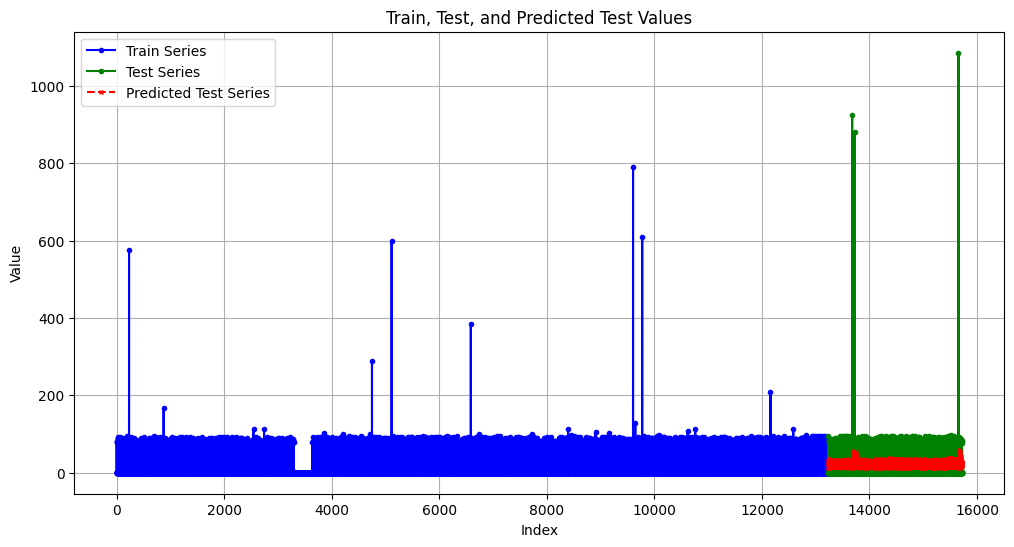

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_convlstm_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_convlstm_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error after on validation: 453.66236083967215


#### GRU

Model that uses gate recurrent units

In [ ]:
# Define input layer
input_layer = Input(shape=(n_steps, n_features), name="input_layer")

# Add GRU layer
gru_layer = GRU(128, activation='relu', return_sequences=True, name="gru_layer")(input_layer)
# Add dropout layer
dropout_layer = Dropout(0.5, name="dropout_layer")(gru_layer)

# Add second GRU layer
gru_layer2 = GRU(64, activation='relu', name="gru_layer2")(dropout_layer)

# Add Dense output layer
output_layer = Dense(1, name="output_layer")(gru_layer2)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer, name="gru_model")

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
print(model.summary())

### Training
# Instantiate the progress bar callback
tqdm_callback = TQDMProgressBar()

# Fit the model with early stopping and learning rate scheduler
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0, callbacks=[early_stopping, lr_scheduler, tqdm_callback])


Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_layer (GRU)                      │ (None, 100, 128)            │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_layer2 (GRU)                     │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

None


Training Progress: 100%|██████████| 10/10 [14:24<00:00, 86.42s/epoch]


In [ ]:
### Performance
# Make predictions on the test data
y_pred = model.predict(X_test)

# Back to original scale
y_train_inversed = scaler.inverse_transform(y_train)
y_pred_inversed = scaler.inverse_transform(y_pred)
y_test_inversed = scaler.inverse_transform(y_test)

# Now calculate the Mean Squared Error in the original scale
mse_gru = mean_squared_error(y_test_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after inverse scaling: {mse_gru}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Mean Squared Error after inverse scaling: 1377.8248017816516


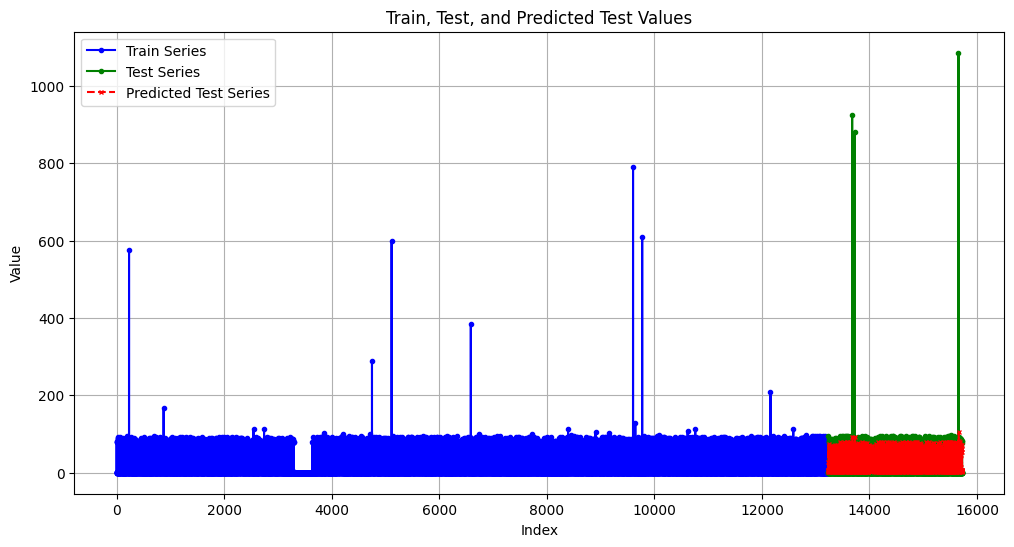

In [ ]:
# Plotting the train, test, and predicted values
plt.figure(figsize=(12, 6))

# Plot the train series
plt.plot(np.arange(len(y_train_inversed)), y_train_inversed, label='Train Series', color='blue', linestyle='-', marker='o', markersize=3)

# Plot the true values (test set)
test_indices = np.arange(len(y_train_inversed), len(y_train_inversed) + len(y_test_inversed))
plt.plot(test_indices, y_test_inversed, label='Test Series', color='green', linestyle='-', marker='o', markersize=3)

# Plot the predicted values on the test set
plt.plot(test_indices, y_pred_inversed, label='Predicted Test Series', color='red', linestyle='--', marker='x', markersize=3)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Train, Test, and Predicted Test Values')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
### Performance on val
# Make predictions on the test data
y_pred = model.predict(X_val)

# Back to original scale
y_pred_inversed = scaler.inverse_transform(y_pred)
y_val_inversed = scaler.inverse_transform(y_val)

# Now calculate the Mean Squared Error in the original scale
mse_gru_val = mean_squared_error(y_val_inversed, y_pred_inversed)

# Print the MSE after rescaling
print(f"Mean Squared Error after on validation: {mse_gru_val}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Mean Squared Error after on validation: 446.00228393830355


## MULTI VARIATE

I now extend my analysis considering the data from all the sensor of the building, seeing if there are some relations between them and how well they're captured

In [ ]:
# Normalize the datasets separately
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform it
scaled_train_data = scaler.fit_transform(train_df.values)

# Transform the test and validation data
scaled_test_data = scaler.transform(test_df.values)
scaled_val_data = scaler.transform(val_df.values)

# Length of the sliding window used to create input sequences
sequence_length = 100

# Create sequences for training and testing datasets
X_train, y_train = create_sequences(scaled_train_data, sequence_length)
X_test, y_test = create_sequences(scaled_test_data, sequence_length)
X_val, y_val = create_sequences(scaled_val_data, sequence_length)

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6)

### LSTM

#### Model 1

Simple model with two lstm layers and dropout

In [ ]:
import tensorflow as tf

def multivariate_lstm_model(X_train_shape, y_train_shape, print_summary=False):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First LSTM Layer
    lstm_layer1 = tf.keras.layers.LSTM(128, return_sequences=True,  name="lstm_layer1")(input_layer)
    # Add a dropout layer
    dropout_1 = Dropout(0.4, name="dropout_layer1")(lstm_layer1)

    # Second LSTM Layer
    lstm_layer2 = tf.keras.layers.LSTM(128, return_sequences=True, name="lstm_layer2")(dropout_1)
    # Add a dropout layer
    dropout_2 = Dropout(0.4, name="dropout_layer2")(lstm_layer2)

    # Third LSTM Layer
    lstm_layer3 = tf.keras.layers.LSTM(128, return_sequences=False, name="lstm_layer3")(dropout_2)
    # Add a dropout layer
    dropout_3 = Dropout(0.4, name="dropout_layer3")(lstm_layer3)

    # Dense Layer (Output layer)
    output_layer = tf.keras.layers.Dense(y_train_shape[1], activation='linear', name="output_layer")(dropout_3)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='multivariate_lstm_model')

    # Compile the model with a learning rate scheduler
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

    if print_summary:
        print(model.summary())

    return model

# Usage
model = multivariate_lstm_model(X_train_shape=X_train.shape, y_train_shape=y_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Model: "multivariate_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer1 (LSTM)                   │ (None, 100, 128)            │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer1 (Dropout)             │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer2 (LSTM)                   │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer2 (Dropout)             │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer3 (LSTM)                   │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer3 (Dropout)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 334,985 (1.28 MB)

 Trainable params: 334,985 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 169s 788ms/step - loss: 0.0053 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 203s 792ms/step - loss: 0.0042 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 205s 805ms/step - loss: 0.0035 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 199s 792ms/step - loss: 0.0034 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 201s 789ms/step - loss: 0.0035 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 200s 778ms/step - loss: 0.0034 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 201s 776ms/step - loss: 0.0034 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 203s 779ms/step - loss: 0.0034 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 204s 788ms/step - loss: 0.0031 - val_loss: 

78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step


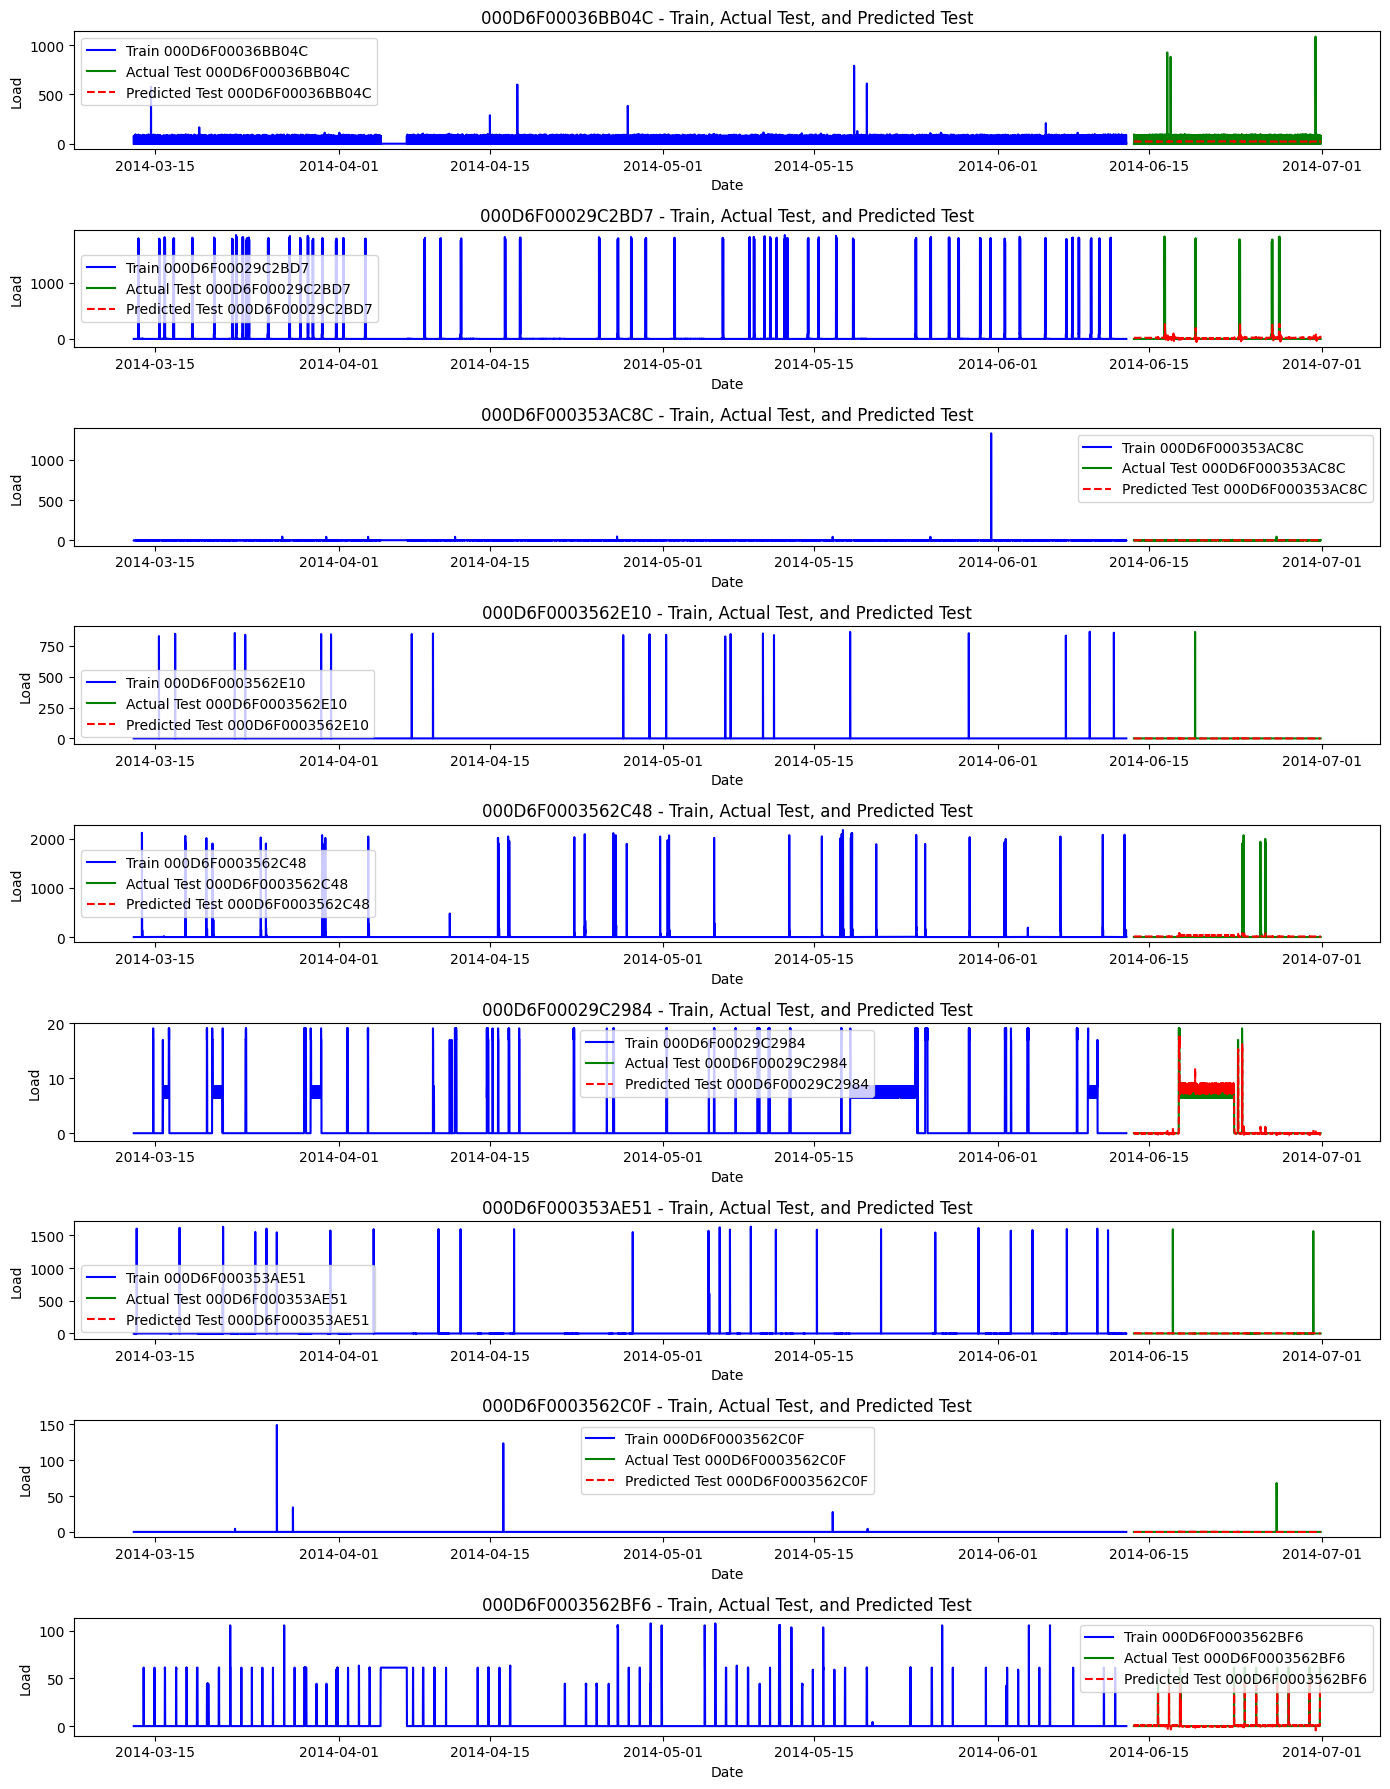

In [ ]:
sensor_names = train_df.columns  # or test_df.columns if they are the same

predictions = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual values
y_test_inversed = scaler.inverse_transform(y_test)
predictions_inversed = scaler.inverse_transform(predictions)
y_train_inversed = scaler.inverse_transform(y_train)

# Step 6: Store the original train and test set dates
dates_train = train_df.index[sequence_length:]  # Starting after the sequence length
dates_test = test_df.index[sequence_length:]    # Same for test set

# Create DataFrames for inversed values with sensor names
y_train_df = pd.DataFrame(y_train_inversed, index=dates_train, columns=sensor_names)
y_test_df = pd.DataFrame(y_test_inversed, index=dates_test, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_test, columns=sensor_names)

# Plotting the Results for Each Sensor
plt.figure(figsize=(14, 18))

num_sensors = len(sensor_names)  # Number of sensors

for i, sensor_name in enumerate(sensor_names):
    plt.subplot(num_sensors, 1, i + 1)

    # Plot the training series
    plt.plot(y_train_df.index, y_train_df[sensor_name], color='blue', label=f'Train {sensor_name}')

    # Plot the actual test series
    plt.plot(y_test_df.index, y_test_df[sensor_name], color='green', label=f'Actual Test {sensor_name}')

    # Plot the predicted test series
    plt.plot(predictions_df.index, predictions_df[sensor_name], color='red', linestyle='dashed', label=f'Predicted Test {sensor_name}')

    plt.title(f'{sensor_name} - Train, Actual Test, and Predicted Test')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_test_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_lstm_1 = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_lstm_1:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_final:
    print(f'MSE for {sensor}: {mse:.4f}')
    mse_multi_lstm_model1_sensor = mse


Average MSE across all sensors: 3170.0939
MSE for 000D6F00036BB04C: 2363.1741


In [ ]:
### Prediction on validation set in a similar way

sensor_names = val_df.columns

predictions = model.predict(X_val)

# Step 5: Inverse transform the predictions and actual values
predictions_inversed = scaler.inverse_transform(predictions)
y_val_inversed = scaler.inverse_transform(y_val)

# Step 6: Store the original validation set dates
dates_val = val_df.index[sequence_length:]

# Create DataFrames for inversed values with sensor names
y_val_df = pd.DataFrame(y_val_inversed, index=dates_val, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_val, columns=sensor_names)

# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_val_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_lstm_1_val = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_lstm_1_val:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_validation:
    print(f'MSE validation for {sensor}: {mse:.4f}')
    mse_multi_lstm_model1_sensor_val = mse


137/137 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step
Average MSE across all sensors: 4487.8940
MSE validation for 000D6F000353AC8C: 424.2213


#### Model 2 (bidirectional)

Variation of the first model using a bidirectional lstm layers and a single last lstm

In [ ]:
def bidirectional_lstm_model(X_train_shape, y_train_shape, print_summary=False):
  # Define the input shape

  # Define the input layer
  input_layer = Input(shape=(X_train_shape[1], X_train_shape[2]), name="input")

  # Add a Bidirectional LSTM layer with return_sequences=True
  x = tf.keras.layers.Bidirectional(LSTM(64, activation='relu', return_sequences=True, name="bidirectional_lstm_1"))(input_layer)

  # Add a dropout layer
  x = Dropout(0.4, name="dropout_layer_1")(x)

  # Add a second LSTM layer
  x = tf.keras.layers.LSTM(64, activation='relu', name="lstm")(x)

  # Add a Dropout layer before the output
  x = Dropout(0.4, name="dropout_layer_3")(x)

  # Add the Dense output layer
  output_layer = tf.keras.layers.Dense(y_train_shape[1], activation='linear', name="output_layer")(x)

  # Create the model
  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='bidirectional_lstm_model')

  # Compile the model with a learning rate scheduler
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

  if print_summary:
    print(model.summary())

  return model

# Define the model
model = bidirectional_lstm_model(X_train_shape=X_train.shape, y_train_shape=y_train.shape, print_summary=True)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Model: "bidirectional_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 128)            │          37,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_1 (Dropout)            │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_3 (Dropout)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,881 (343.29 KB)

 Trainable params: 87,881 (343.29 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 67s 302ms/step - loss: 0.0062 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 75s 268ms/step - loss: 76.5622 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 85s 284ms/step - loss: 0.0038 - val_loss: 0.0020 - learning_rate: 0.0010
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0016
Test Loss: 0.0019410771783441305


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step


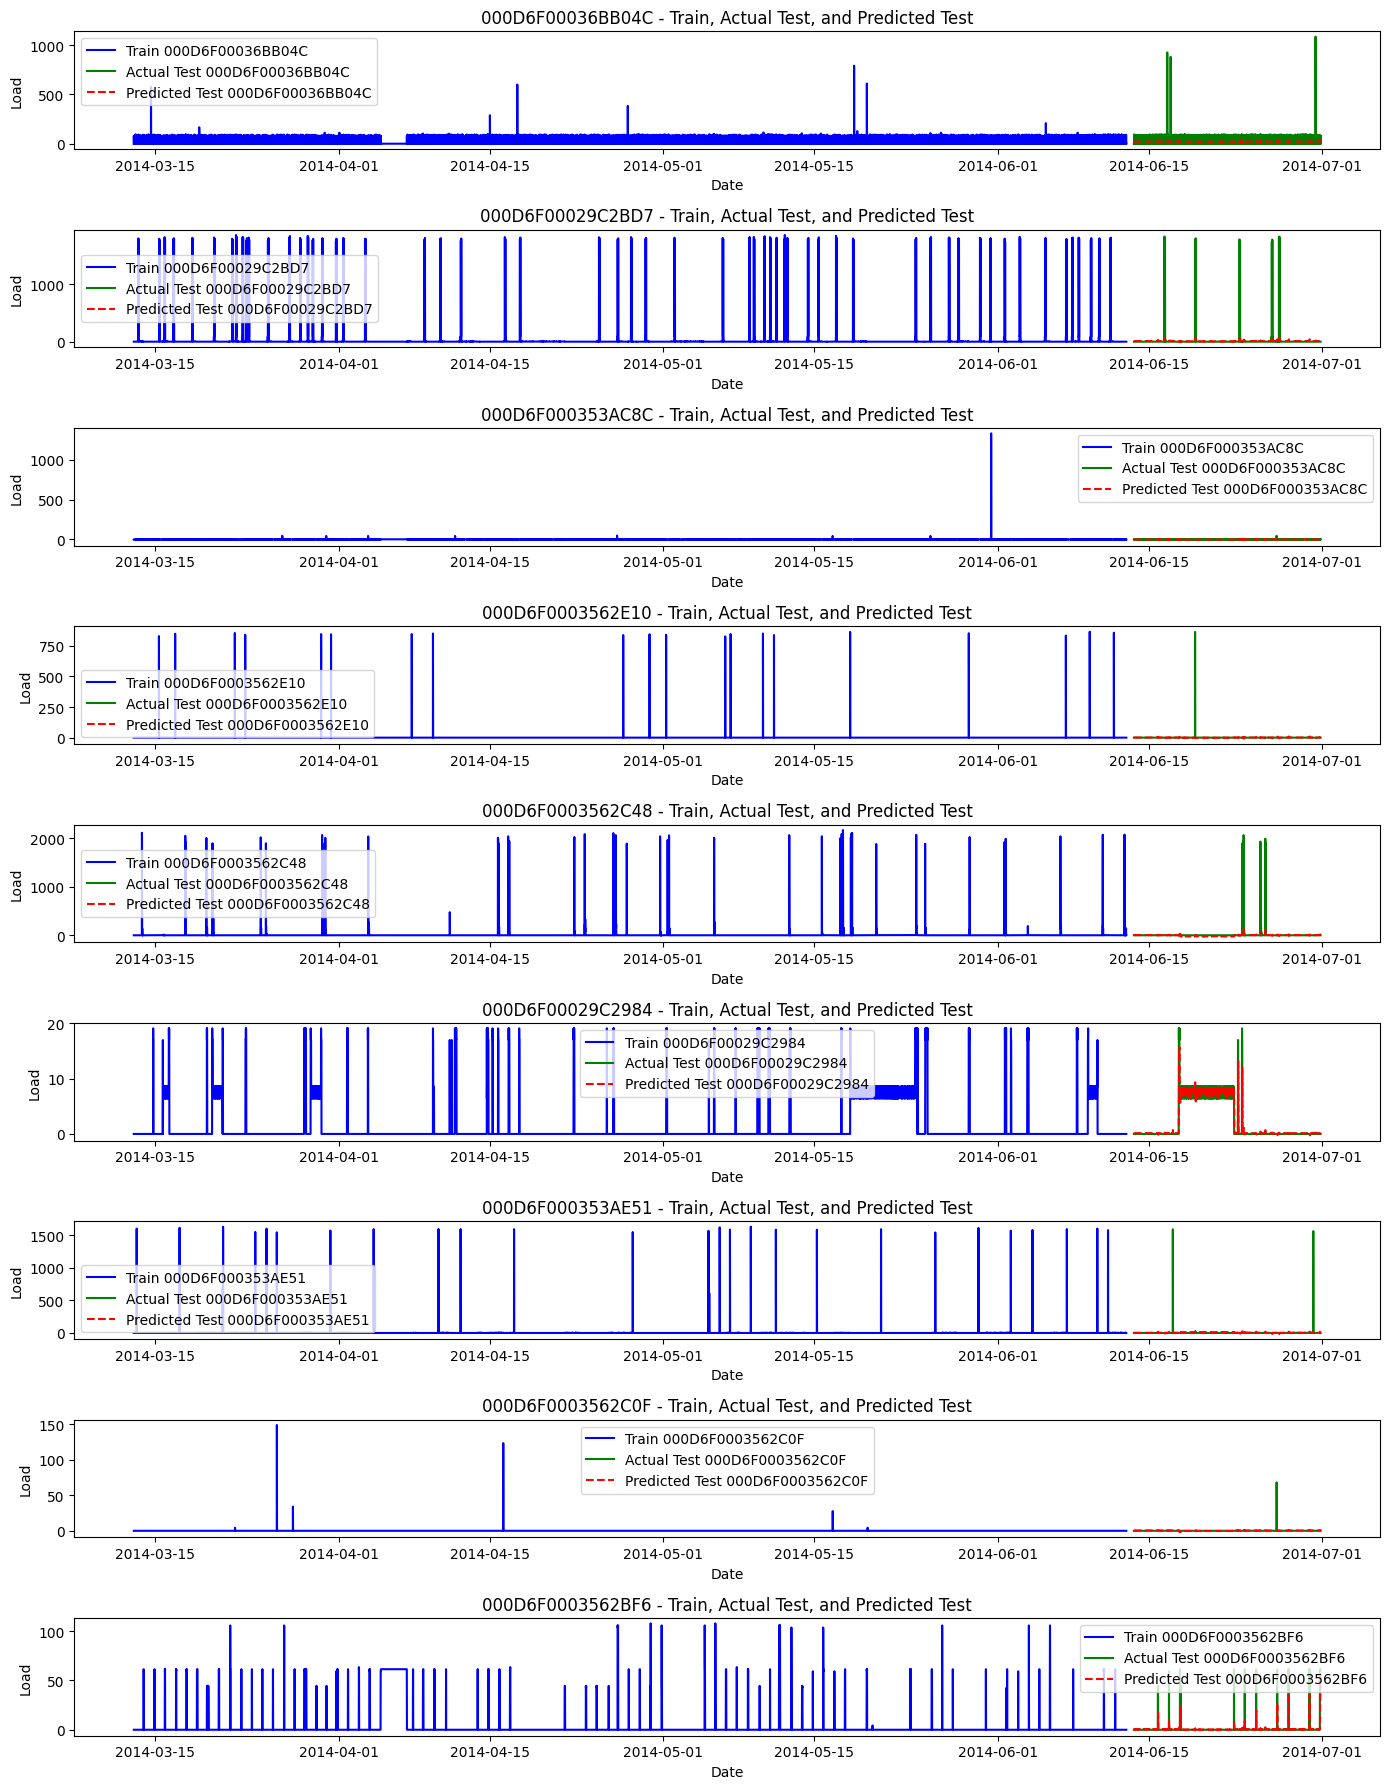

In [ ]:
sensor_names = train_df.columns  # or test_df.columns if they are the same

predictions = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual values
y_test_inversed = scaler.inverse_transform(y_test)
predictions_inversed = scaler.inverse_transform(predictions)
y_train_inversed = scaler.inverse_transform(y_train)

# Step 6: Store the original train and test set dates
dates_train = train_df.index[sequence_length:]  # Starting after the sequence length
dates_test = test_df.index[sequence_length:]    # Same for test set

# Create DataFrames for inversed values with sensor names
y_train_df = pd.DataFrame(y_train_inversed, index=dates_train, columns=sensor_names)
y_test_df = pd.DataFrame(y_test_inversed, index=dates_test, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_test, columns=sensor_names)

# Plotting the Results for Each Sensor
plt.figure(figsize=(14, 18))

num_sensors = len(sensor_names)  # Number of sensors

for i, sensor_name in enumerate(sensor_names):
    plt.subplot(num_sensors, 1, i + 1)

    # Plot the training series
    plt.plot(y_train_df.index, y_train_df[sensor_name], color='blue', label=f'Train {sensor_name}')

    # Plot the actual test series
    plt.plot(y_test_df.index, y_test_df[sensor_name], color='green', label=f'Actual Test {sensor_name}')

    # Plot the predicted test series
    plt.plot(predictions_df.index, predictions_df[sensor_name], color='red', linestyle='dashed', label=f'Predicted Test {sensor_name}')

    plt.title(f'{sensor_name} - Train, Actual Test, and Predicted Test')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_test_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_lstm_2 = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_lstm_2:.4f}')

# Optionally, print MSE for each individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_final:
    print(f'MSE for {sensor}: {mse:.4f}')
    mse_multi_lstm_model2_sensor = mse



Average MSE across all sensors: 3237.9944
MSE for 000D6F00036BB04C: 2360.2264


In [ ]:
### Prediction on validation set in a similar way

sensor_names = val_df.columns

predictions = model.predict(X_val)

# Step 5: Inverse transform the predictions and actual values
predictions_inversed = scaler.inverse_transform(predictions)
y_val_inversed = scaler.inverse_transform(y_val)

# Step 6: Store the original validation set dates
dates_val = val_df.index[sequence_length:]

# Create DataFrames for inversed values with sensor names
y_val_df = pd.DataFrame(y_val_inversed, index=dates_val, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_val, columns=sensor_names)

# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_val_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_lstm_2_val = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_lstm_2_val:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_validation:
    print(f'MSE validation for {sensor}: {mse:.4f}')
    mse_multi_lstm_model2_sensor_val = mse


137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
Average MSE across all sensors: 4596.5093
MSE validation for 000D6F000353AC8C: 429.2742


### 1DCNN

#### Model 1

1D CNN model for multivariate time series with two Conv1D layers and a last flattening layer

In [ ]:
import tensorflow as tf

def cnn_1d_model(X_train_shape, y_train_shape, print_summary=False):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Convolutional Layer
    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu', name="conv1")(input_layer)
    # Add a dropout layer
    dropout_1 = Dropout(0.4, name="dropout_layer1")(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool1")(dropout_1)

    # Second Convolutional Layer
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=16, activation='relu', name="conv2")(pool1)
    # Add a dropout layer
    dropout_2 = Dropout(0.4, name="dropout_layer2")(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool2")(dropout_2)

    # Flatten the output
    flatten = tf.keras.layers.Flatten(name="flatten")(pool2)

    # Output Layer
    output_layer = tf.keras.layers.Dense(y_train_shape[1], activation='linear', name="output_layer")(flatten)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='cnn_1d_model')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    if print_summary:
        print(model.summary())

    return model

# Usage
model = cnn_1d_model(X_train_shape=X_train.shape, y_train_shape=y_train.shape, print_summary=True)

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

cnn_model_type =1

Model: "cnn_1d_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 69, 64)              │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer1 (Dropout)             │ (None, 69, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 34, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 19, 32)              │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer2 (Dropout)             │ (None, 19, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 9)                   │           2,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,897 (210.54 KB)

 Trainable params: 53,897 (210.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0079 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0056 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0049 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0052 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0048 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0045 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0045 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.0044 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0040 - val_loss: 0.0033 - learning_rate: 

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


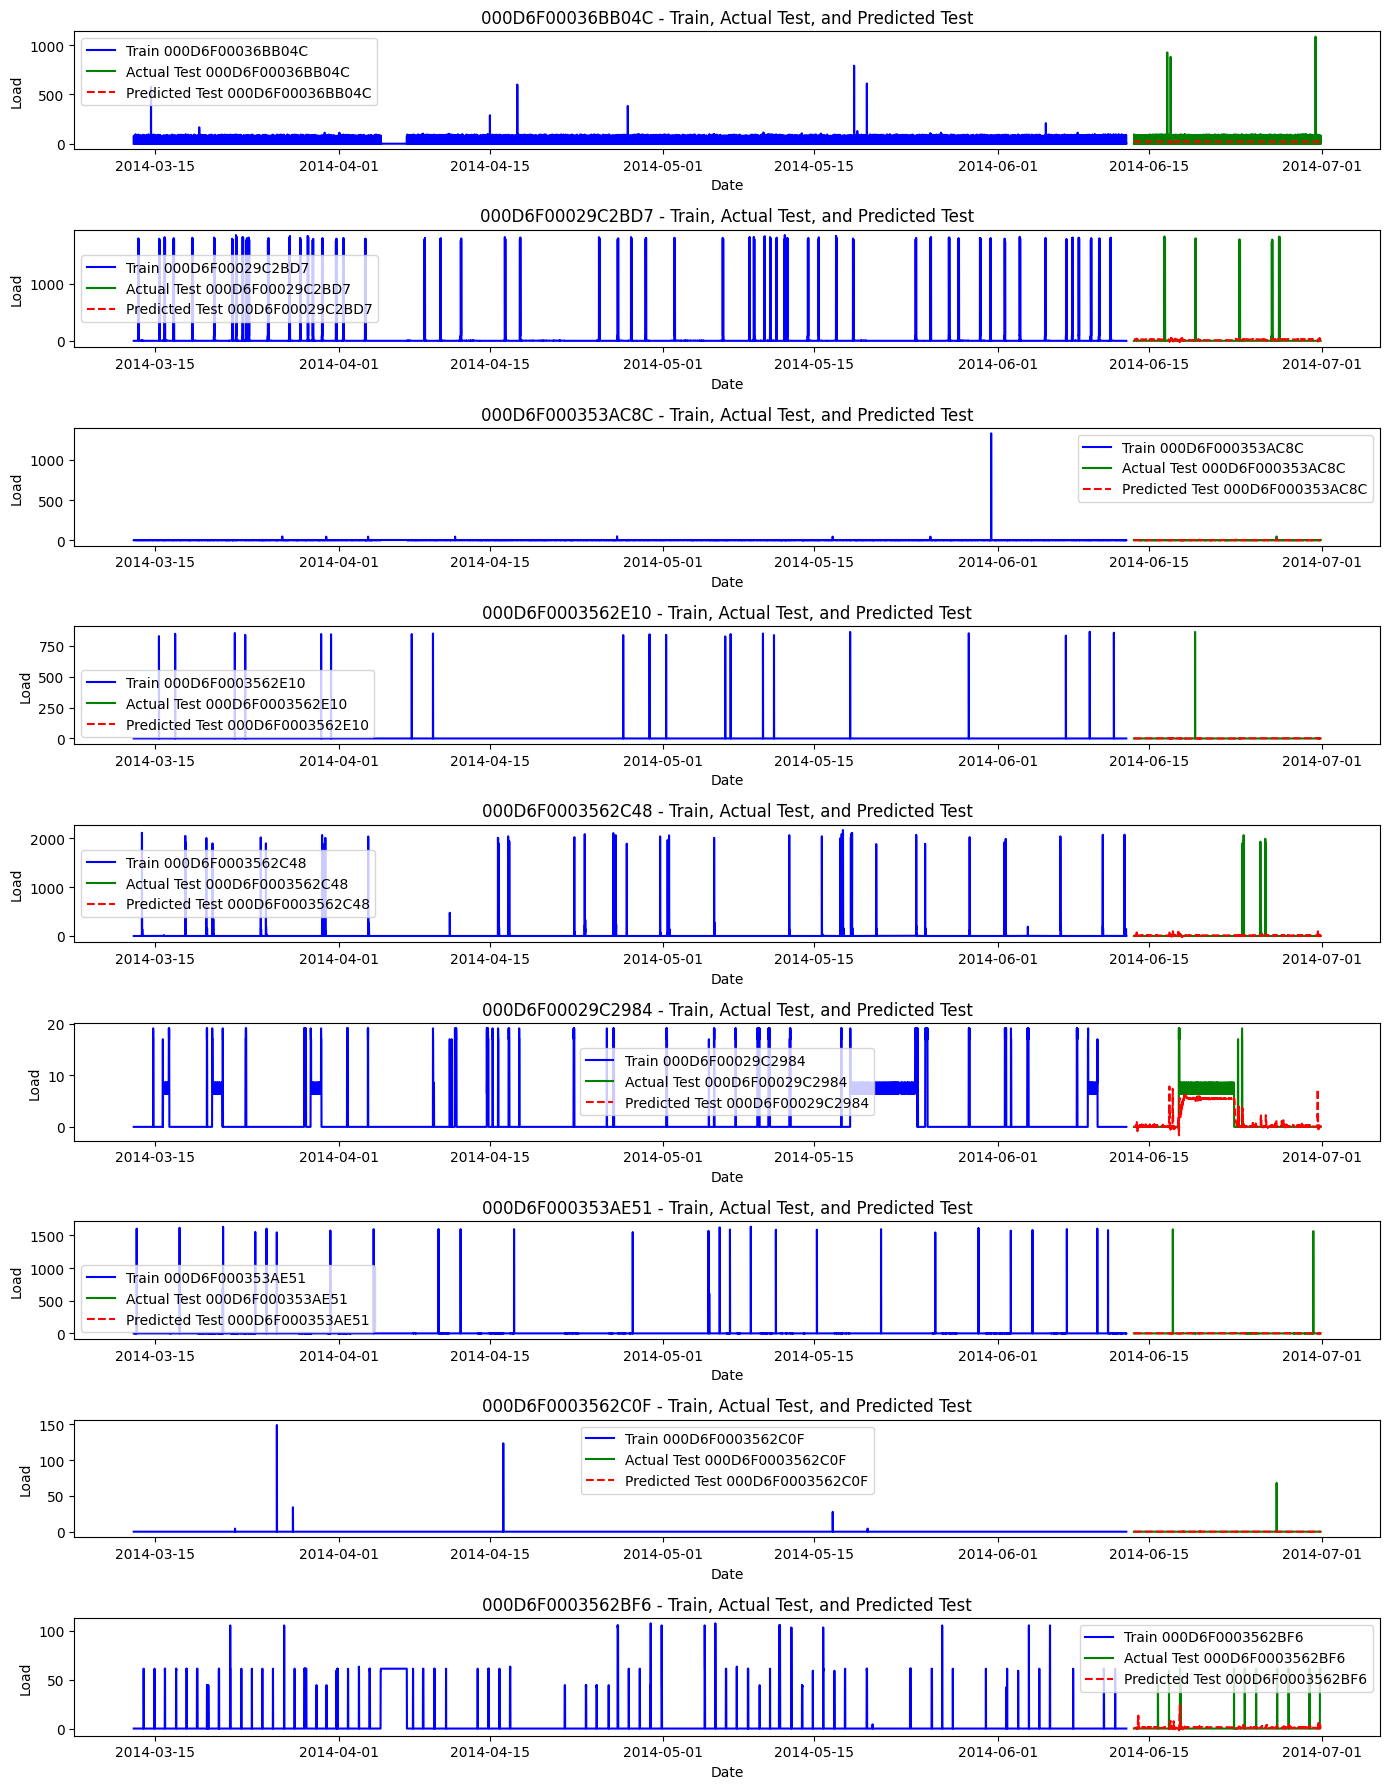

In [ ]:
sensor_names = train_df.columns  # or test_df.columns if they are the same

predictions = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual values
y_test_inversed = scaler.inverse_transform(y_test)
predictions_inversed = scaler.inverse_transform(predictions)
y_train_inversed = scaler.inverse_transform(y_train)

# Step 6: Store the original train and test set dates
dates_train = train_df.index[sequence_length:]  # Starting after the sequence length
dates_test = test_df.index[sequence_length:]    # Same for test set

# Create DataFrames for inversed values with sensor names
y_train_df = pd.DataFrame(y_train_inversed, index=dates_train, columns=sensor_names)
y_test_df = pd.DataFrame(y_test_inversed, index=dates_test, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_test, columns=sensor_names)

# Plotting the Results for Each Sensor
plt.figure(figsize=(14, 18))

num_sensors = len(sensor_names)  # Number of sensors

for i, sensor_name in enumerate(sensor_names):
    plt.subplot(num_sensors, 1, i + 1)

    # Plot the training series
    plt.plot(y_train_df.index, y_train_df[sensor_name], color='blue', label=f'Train {sensor_name}')

    # Plot the actual test series
    plt.plot(y_test_df.index, y_test_df[sensor_name], color='green', label=f'Actual Test {sensor_name}')

    # Plot the predicted test series
    plt.plot(predictions_df.index, predictions_df[sensor_name], color='red', linestyle='dashed', label=f'Predicted Test {sensor_name}')

    plt.title(f'{sensor_name} - Train, Actual Test, and Predicted Test')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_test_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_cnn_1 = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_cnn_1:.4f}')

# Optionally, print MSE for each individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_final:
    print(f'MSE for {sensor}: {mse:.4f}')
    mse_multi_cnn_model1_sensor = mse



Average MSE across all sensors: 3318.7338
MSE for 000D6F00036BB04C: 2375.8735


In [ ]:
### Prediction on validation set in a similar way

sensor_names = val_df.columns

predictions = model.predict(X_val)

# Step 5: Inverse transform the predictions and actual values
predictions_inversed = scaler.inverse_transform(predictions)
y_val_inversed = scaler.inverse_transform(y_val)

# Step 6: Store the original validation set dates
dates_val = val_df.index[sequence_length:]

# Create DataFrames for inversed values with sensor names
y_val_df = pd.DataFrame(y_val_inversed, index=dates_val, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_val, columns=sensor_names)

# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_val_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_cnn_1_val = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_cnn_1_val:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_validation:
    print(f'MSE validation for {sensor}: {mse:.4f}')
    mse_multi_cnn_model1_sensor_val = mse


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Average MSE across all sensors: 4691.6279
MSE validation for 000D6F000353AC8C: 424.5153


#### Model 2


Variation of the previous model using one more layer and GlobalMaxPooling instead of a flattening layer

In [ ]:
def cnn_1d_model_variation(X_train_shape, y_train_shape, print_summary=False):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Convolutional Layer
    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu', name="conv1")(input_layer)
    # Add a dropout layer
    dropout_1 = Dropout(0.4, name="dropout_layer1")(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool1")(dropout_1)

    # Second Convolutional Layer
    conv2 = tf.keras.layers.Conv1D(filters=96, kernel_size=16, activation='relu', name="conv2")(pool1)
    # Add a dropout layer
    dropout_2 = Dropout(0.4, name="dropout_layer2")(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool2")(dropout_2)

    # Third Convolutional Layer (additional layer)
    conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu', name="conv3")(pool2)
    dropout_3 = Dropout(0.4, name="dropout_layer3")(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool3")(dropout_3)

    # Global Max Pooling
    global_pool = tf.keras.layers.GlobalMaxPooling1D(name="global_pool")(pool3)

    # Output Layer
    output_layer = tf.keras.layers.Dense(y_train_shape[1], activation='linear', name="output_layer")(global_pool)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='cnn_1d_model_variation')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    if print_summary:
        print(model.summary())

    return model

# Usage
model = cnn_1d_model_variation(X_train_shape=X_train.shape, y_train_shape=y_train.shape, print_summary=True)

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

cnn_model_type =2

Model: "cnn_1d_model_variation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 69, 64)              │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer1 (Dropout)             │ (None, 69, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 34, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 19, 96)              │          98,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer2 (Dropout)             │ (None, 19, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 9, 96)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 2, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer3 (Dropout)             │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling1D)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_pool (GlobalMaxPooling1D)     │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,489 (845.66 KB)

 Trainable params: 216,489 (845.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 0.0072 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0054 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0049 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 0.0045 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 0.0043 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0043 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0040 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0041 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0038 - val_loss: 0.0034 - learning_

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


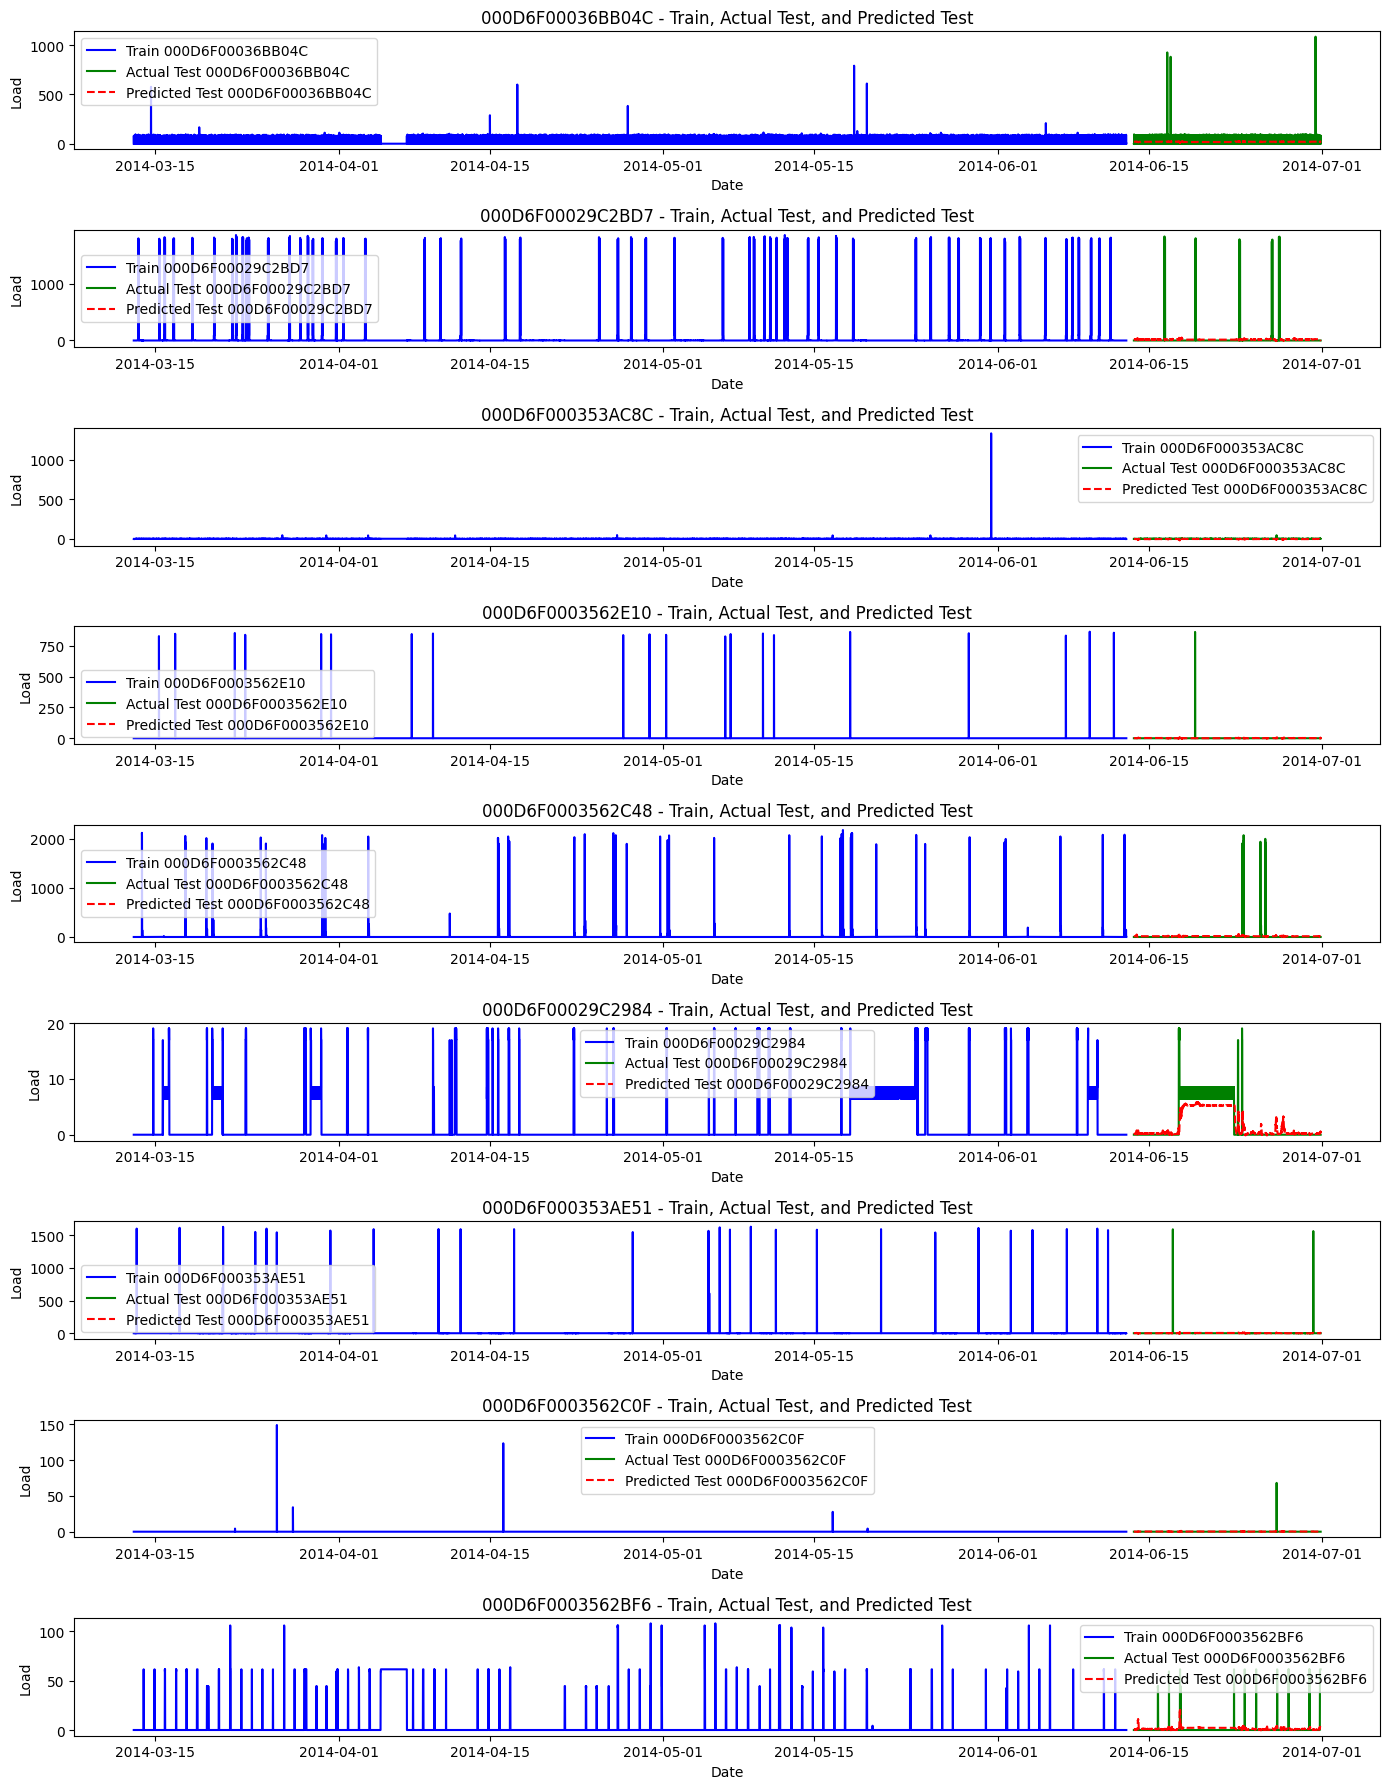

In [ ]:
sensor_names = train_df.columns  # or test_df.columns if they are the same

predictions = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual values
y_test_inversed = scaler.inverse_transform(y_test)
predictions_inversed = scaler.inverse_transform(predictions)
y_train_inversed = scaler.inverse_transform(y_train)

# Step 6: Store the original train and test set dates
dates_train = train_df.index[sequence_length:]  # Starting after the sequence length
dates_test = test_df.index[sequence_length:]    # Same for test set

# Create DataFrames for inversed values with sensor names
y_train_df = pd.DataFrame(y_train_inversed, index=dates_train, columns=sensor_names)
y_test_df = pd.DataFrame(y_test_inversed, index=dates_test, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_test, columns=sensor_names)

# Plotting the Results for Each Sensor
plt.figure(figsize=(14, 18))

num_sensors = len(sensor_names)  # Number of sensors

for i, sensor_name in enumerate(sensor_names):
    plt.subplot(num_sensors, 1, i + 1)

    # Plot the training series
    plt.plot(y_train_df.index, y_train_df[sensor_name], color='blue', label=f'Train {sensor_name}')

    # Plot the actual test series
    plt.plot(y_test_df.index, y_test_df[sensor_name], color='green', label=f'Actual Test {sensor_name}')

    # Plot the predicted test series
    plt.plot(predictions_df.index, predictions_df[sensor_name], color='red', linestyle='dashed', label=f'Predicted Test {sensor_name}')

    plt.title(f'{sensor_name} - Train, Actual Test, and Predicted Test')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_test_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_cnn_2 = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_cnn_2:.4f}')

# Optionally, print MSE for each individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_final:
    print(f'MSE for {sensor}: {mse:.4f}')
    mse_multi_cnn_model2_sensor = mse


Average MSE across all sensors: 3302.2185
MSE for 000D6F00036BB04C: 2377.2540


In [ ]:
### Prediction on validation set in a similar way

sensor_names = val_df.columns

predictions = model.predict(X_val)

# Step 5: Inverse transform the predictions and actual values
predictions_inversed = scaler.inverse_transform(predictions)
y_val_inversed = scaler.inverse_transform(y_val)

# Step 6: Store the original validation set dates
dates_val = val_df.index[sequence_length:]

# Create DataFrames for inversed values with sensor names
y_val_df = pd.DataFrame(y_val_inversed, index=dates_val, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_val, columns=sensor_names)

# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_val_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_cnn_2_val = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_cnn_2_val:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_validation:
    print(f'MSE validation for {sensor}: {mse:.4f}')
    mse_multi_cnn_model2_sensor_val = mse


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Average MSE across all sensors: 4676.9026
MSE validation for 000D6F000353AC8C: 436.3905


### CONVLSTM


ConvLSTM for multivariate time series, using tanh activation function instead of relu

In [ ]:
import tensorflow as tf

def conv_lstm_1d_model(X_train_shape, y_train_shape, print_summary=False):
    # Input layer
    input_layer = tf.keras.layers.Input(shape=(X_train_shape[1], X_train_shape[2]), name="input_layer")

    # First Convolutional Layer
    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=64, activation='tanh', padding='same', name="conv1")(input_layer)
    # Add a dropout layer
    dropout_1 = Dropout(0.4, name="dropout_layer1")(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool1")(dropout_1)

    # Second Convolutional Layer
    conv2 = tf.keras.layers.Conv1D(filters=96, kernel_size=32, activation='tanh', padding='same', name="conv2")(pool1)
    # Add a dropout layer
    dropout_2 = Dropout(0.4, name="dropout_layer2")(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2, name="pool2")(dropout_2)

    # Third Convolutional Layer
    conv3 = tf.keras.layers.Conv1D(filters=96, kernel_size=16, activation='tanh',  name="conv3")(pool2)
    # Add a dropout layer
    dropout_3 = Dropout(0.4, name="dropout_layer3")(conv3)

    # Add LSTM Layer
    lstm = tf.keras.layers.LSTM(64, activation='tanh', name="lstm")(dropout_3)

    # Output Layer
    output_layer = tf.keras.layers.Dense(y_train_shape[1], activation='linear', name="output_layer")(lstm)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer, name='conv_lstm_1d_model')

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    if print_summary:
        print(model.summary())

    return model

# Usage
model = conv_lstm_1d_model(X_train_shape=X_train.shape, y_train_shape=y_train.shape, print_summary=True)

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Model: "conv_lstm_1d_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 100, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer1 (Dropout)             │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 50, 96)              │         196,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer2 (Dropout)             │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 25, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 10, 96)              │         147,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer3 (Dropout)             │ (None, 10, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,985 (1.61 MB)

 Trainable params: 422,985 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 51s 229ms/step - loss: 0.0068 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 226ms/step - loss: 0.0038 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 219ms/step - loss: 0.0039 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 83s 225ms/step - loss: 0.0035 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 49s 236ms/step - loss: 0.0033 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 84s 235ms/step - loss: 0.0032 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 47s 228ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - loss: 0.0027 - val_loss: 0.0027 - 

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step


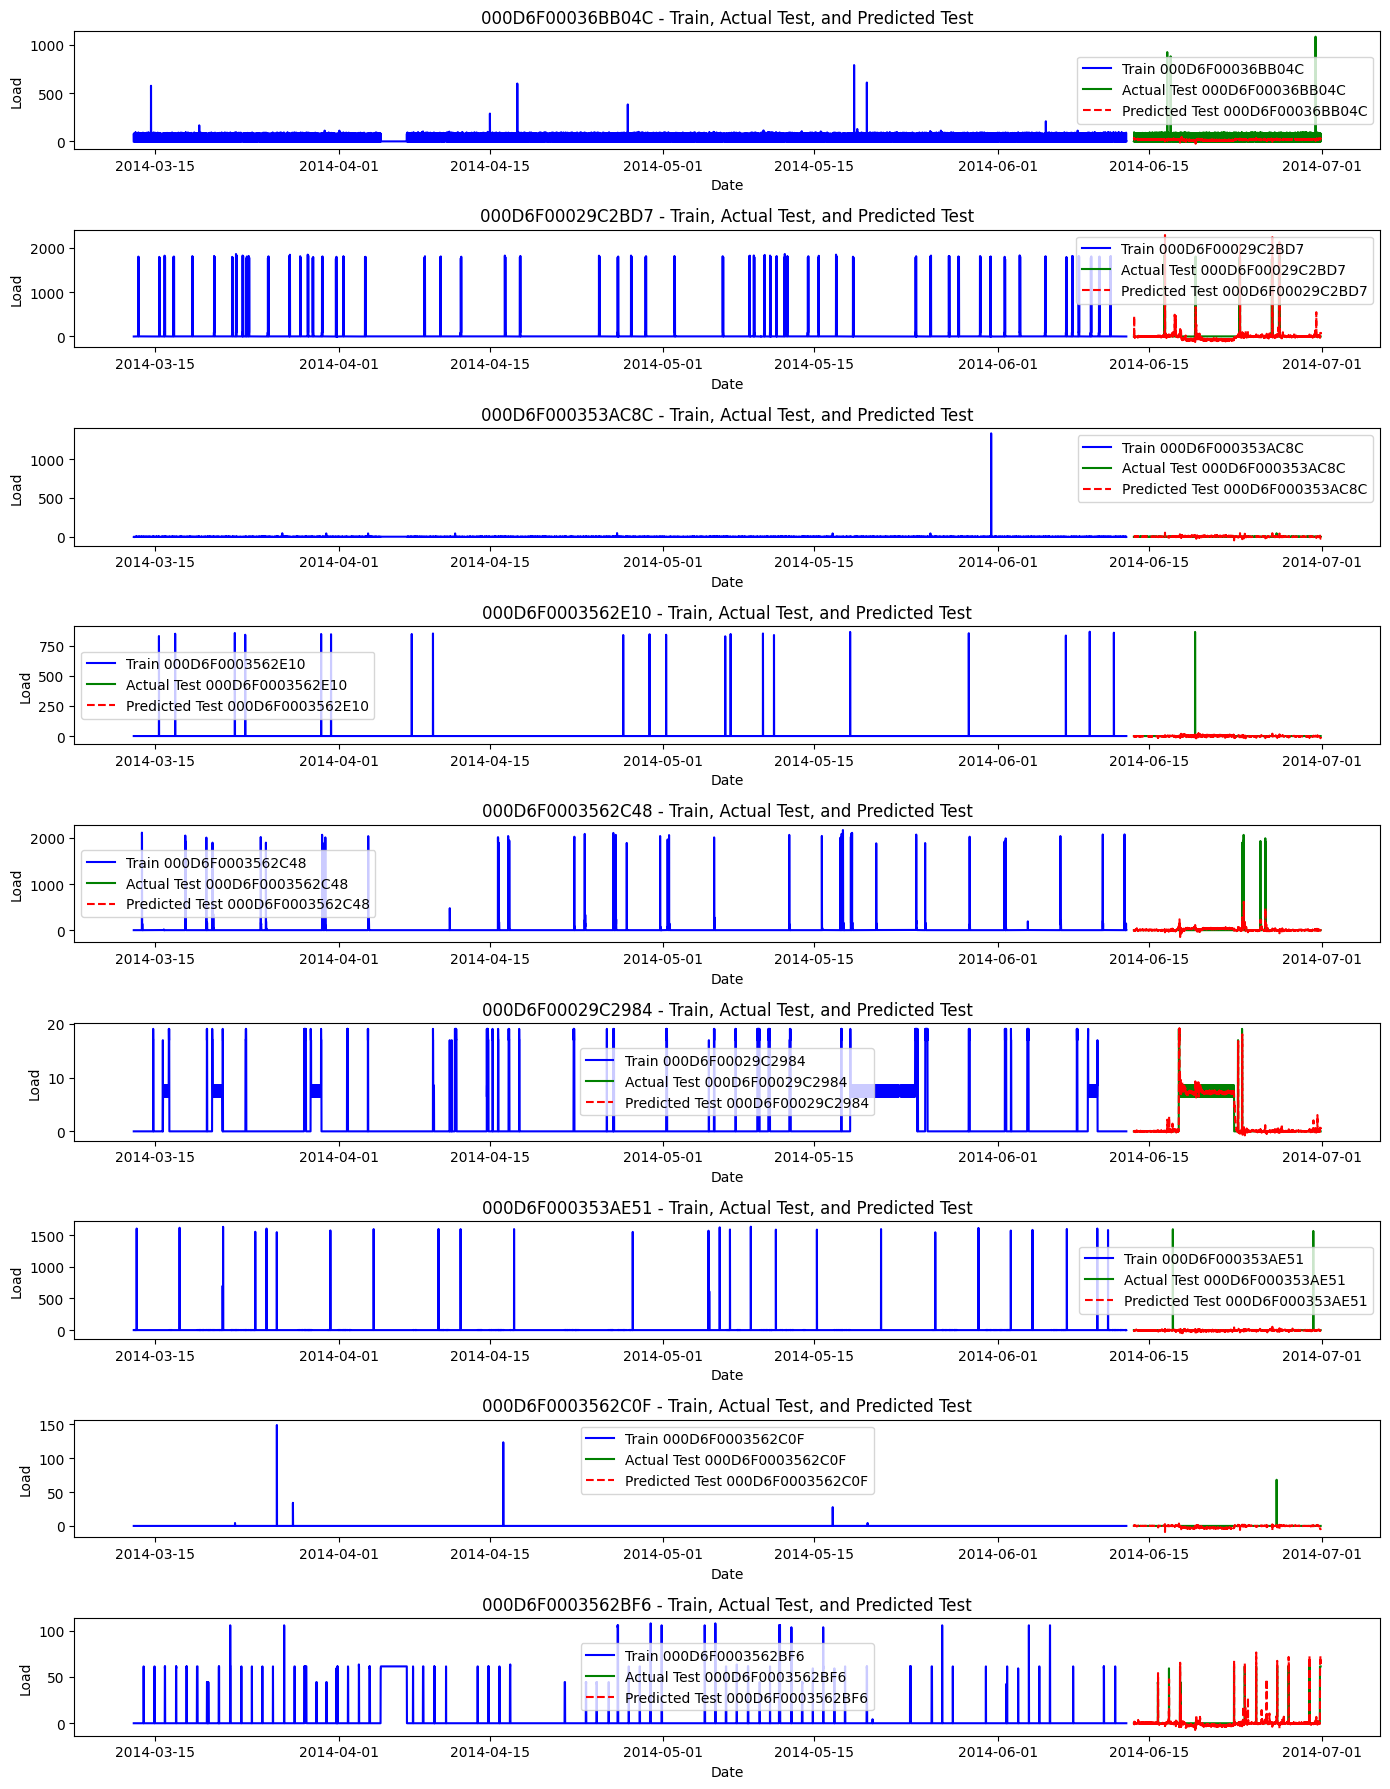

In [ ]:
sensor_names = train_df.columns  # or test_df.columns if they are the same

predictions = model.predict(X_test)

# Step 5: Inverse transform the predictions and actual values
y_test_inversed = scaler.inverse_transform(y_test)
predictions_inversed = scaler.inverse_transform(predictions)
y_train_inversed = scaler.inverse_transform(y_train)

# Step 6: Store the original train and test set dates
dates_train = train_df.index[sequence_length:]  # Starting after the sequence length
dates_test = test_df.index[sequence_length:]    # Same for test set

# Create DataFrames for inversed values with sensor names
y_train_df = pd.DataFrame(y_train_inversed, index=dates_train, columns=sensor_names)
y_test_df = pd.DataFrame(y_test_inversed, index=dates_test, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_test, columns=sensor_names)

# Plotting the Results for Each Sensor
plt.figure(figsize=(14, 18))

num_sensors = len(sensor_names)  # Number of sensors

for i, sensor_name in enumerate(sensor_names):
    plt.subplot(num_sensors, 1, i + 1)

    # Plot the training series
    plt.plot(y_train_df.index, y_train_df[sensor_name], color='blue', label=f'Train {sensor_name}')

    # Plot the actual test series
    plt.plot(y_test_df.index, y_test_df[sensor_name], color='green', label=f'Actual Test {sensor_name}')

    # Plot the predicted test series
    plt.plot(predictions_df.index, predictions_df[sensor_name], color='red', linestyle='dashed', label=f'Predicted Test {sensor_name}')

    plt.title(f'{sensor_name} - Train, Actual Test, and Predicted Test')
    plt.xlabel('Date')
    plt.ylabel('Load')
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_test_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_convlstm = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_convlstm:.4f}')

# Optionally, print MSE for each individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_final:
    print(f'MSE for {sensor}: {mse:.4f}')
    mse_multi_convlstm_sensor = mse



Average MSE across all sensors: 3108.2272
MSE for 000D6F00036BB04C: 2343.1805


In [ ]:
### Prediction on validation set in a similar way

sensor_names = val_df.columns

predictions = model.predict(X_val)

# Step 5: Inverse transform the predictions and actual values
predictions_inversed = scaler.inverse_transform(predictions)
y_val_inversed = scaler.inverse_transform(y_val)

# Step 6: Store the original validation set dates
dates_val = val_df.index[sequence_length:]

# Create DataFrames for inversed values with sensor names
y_val_df = pd.DataFrame(y_val_inversed, index=dates_val, columns=sensor_names)
predictions_df = pd.DataFrame(predictions_inversed, index=dates_val, columns=sensor_names)

# Calculate the MSE for each sensor
mse_values = []

for sensor_name in sensor_names:
    mse = mean_squared_error(y_val_df[sensor_name], predictions_df[sensor_name])
    mse_values.append(mse)

# Calculate the average MSE across all sensors
average_mse_convlstm_val = sum(mse_values) / len(sensor_names)

# Print the average MSE
print(f'Average MSE across all sensors: {average_mse_convlstm_val:.4f}')

# Optionally, print MSE for an individual sensor
for sensor, mse in zip(sensor_names, mse_values):
  if sensor == sensor_name_validation:
    print(f'MSE validation for {sensor}: {mse:.4f}')
    mse_multi_convlstm_val = mse


137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Average MSE across all sensors: 4287.3540
MSE validation for 000D6F000353AC8C: 456.0082


## Comparing MSE

In [ ]:
from tabulate import tabulate

# Data for the table
data_test = [
    ["MSE multivariate LSTM Model 1 for " + sensor_name_final, f"{mse_multi_lstm_model1_sensor:.4f}"],
    ["MSE multivariate LSTM Model 2 for " + sensor_name_final, f"{mse_multi_lstm_model2_sensor:.4f}"],
    ["MSE multivariate CNN Model 1 for " + sensor_name_final, f"{mse_multi_cnn_model1_sensor:.4f}"],
    ["MSE multivariate CNN Model 2 for " + sensor_name_final, f"{mse_multi_cnn_model2_sensor:.4f}"],
    ["MSE multivariate CONVLSTM for " + sensor_name_final, f"{mse_multi_convlstm_sensor:.4f}"],
    [f"MSE ARIMA for sensor {sensor_name_final}", f"{mse_arima:.4f}"],
    [f"MSE Simple for sensor {sensor_name_final}", f"{mse_simple:.4f}"],
    [f"MSE Multilayered for sensor {sensor_name_final}", f"{mse_multilayered:.4f}"],
    [f"MSE Bidirectional for sensor {sensor_name_final}", f"{mse_bidirectional:.4f}"],
    [f"MSE CNN for sensor {sensor_name_final}", f"{mse_cnn_1:.4f}"],
    [f"MSE ConvLSTM for sensor {sensor_name_final}", f"{mse_convlstm:.4f}"],
    [f"MSE GRU for sensor {sensor_name_final}", f"{mse_gru:.4f}"],
]

# Sort data by MSE in descending order
data_test_sorted = sorted(data_test, key=lambda x: float(x[1]), reverse=False)

# Print the table
print(tabulate(data_test_sorted, headers=["Model", "MSE on test"], tablefmt="grid"))

# Find the best model (smallest MSE)
best_model = min(data_test_sorted, key=lambda x: float(x[1]))
print(f"\nThe best model is {best_model[0]} with MSE {best_model[1]}.")


+----------------------------------------------------+---------------+
| Model                                              |   MSE on test |
+====================================================+===============+
| MSE GRU for sensor 000D6F00036BB04C                |       1377.82 |
+----------------------------------------------------+---------------+
| MSE Bidirectional for sensor 000D6F00036BB04C      |       1423.49 |
+----------------------------------------------------+---------------+
| MSE Simple for sensor 000D6F00036BB04C             |       1624.59 |
+----------------------------------------------------+---------------+
| MSE ConvLSTM for sensor 000D6F00036BB04C           |       2210.7  |
+----------------------------------------------------+---------------+
| MSE multivariate CONVLSTM for 000D6F00036BB04C     |       2343.18 |
+----------------------------------------------------+---------------+
| MSE multivariate LSTM Model 2 for 000D6F00036BB04C |       2360.23 |
+-----

In [ ]:
# Data for the table
data_val = [
    ["MSE multivariate LSTM Model 1 for " + sensor_name_validation, f"{mse_multi_lstm_model1_sensor_val:.4f}"],
    ["MSE multivariate LSTM Model 2 for " + sensor_name_validation, f"{mse_multi_lstm_model2_sensor_val:.4f}"],
    ["MSE multivariate CNN Model 1 for " + sensor_name_validation, f"{mse_multi_cnn_model1_sensor_val:.4f}"],
    ["MSE multivariate CNN Model 2 for " + sensor_name_validation, f"{mse_multi_cnn_model2_sensor_val:.4f}"],
    ["MSE multivariate CONVLSTM for " + sensor_name_validation, f"{mse_multi_convlstm_val:.4f}"],
    [f"MSE Simple for sensor {sensor_name_validation}", f"{mse_simple_val:.4f}"],
    [f"MSE Multilayered for sensor {sensor_name_validation}", f"{mse_multilayered_val:.4f}"],
    [f"MSE Bidirectional for sensor {sensor_name_validation}", f"{mse_bidirectional_val:.4f}"],
    [f"MSE CNN for sensor {sensor_name_validation}", f"{mse_cnn_val:.4f}"],
    [f"MSE ConvLSTM for sensor {sensor_name_validation}", f"{mse_convlstm_val:.4f}"],
    [f"MSE GRU for sensor {sensor_name_validation}", f"{mse_gru_val:.4f}"],
]

# Sort data by MSE in descending order
data_val_sorted = sorted(data_val, key=lambda x: float(x[1]), reverse=False)

# Print the table
print(tabulate(data_val_sorted, headers=["Model", "MSE on validation"], tablefmt="grid"))

# Find the best model (smallest MSE)
best_model = min(data_val_sorted, key=lambda x: float(x[1]))
print(f"\nThe best model is {best_model[0]} with MSE {best_model[1]}.")


+----------------------------------------------------+---------------------+
| Model                                              |   MSE on validation |
+====================================================+=====================+
| MSE multivariate LSTM Model 1 for 000D6F000353AC8C |             424.221 |
+----------------------------------------------------+---------------------+
| MSE multivariate CNN Model 1 for 000D6F000353AC8C  |             424.515 |
+----------------------------------------------------+---------------------+
| MSE multivariate LSTM Model 2 for 000D6F000353AC8C |             429.274 |
+----------------------------------------------------+---------------------+
| MSE multivariate CNN Model 2 for 000D6F000353AC8C  |             436.39  |
+----------------------------------------------------+---------------------+
| MSE Simple for sensor 000D6F000353AC8C             |             439.01  |
+----------------------------------------------------+---------------------+

## Final considerations

Based on the results, the GRU model  outperformed other models for sensor data from 'building_1', achieving the lowest MSE (1377.82) on the test set. The Bidirectional and Simple LSTM models followed closely, indicating that recurrent architectures generally perform better on this data compared to convolutional models or hybrid approaches like ConvLSTM.

In the validation set ('building_0'), the multivariate LSTM Model 1 had the best performance (MSE 424.22), closely followed by the multivariate CNN Model 1. This suggests that the multivariate models, which are trained on a broader dataset, perform better when applied to unseen data from different sensors.

Compared to a standard statistical model like ARIMA, the deep learning models achieved better performance